# Import Libraries, Load Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import stats

In [2]:
annotations = pd.read_csv("dataset/phase_2_TRAIN_8d8d624e3190984c_05dcbf4_MLPC2021_raw_annotations_generic.csv")
features = pd.read_csv("dataset/phase_2_TRAIN_ab71fa4d86c94323_05dcbf4_MLPC2021_features_generic.csv")

piece_ids = annotations.piece.unique()
students = annotations.student.unique()

# Exploring Annotations

## Computing simple statistics for each piece

mean, median, variance / sd

In [3]:
plot_data = pd.DataFrame(columns=["piece", "a_sd", "v_sd", "a_variance", "v_variance", "a_mean", "v_mean", "a_median", "v_median"])

for piece in piece_ids:
    piece_annotations = annotations[annotations.piece == piece]
    a = piece_annotations.arousal
    v = piece_annotations.valence
    a_variance = a.var()
    a_sd = np.sqrt(a_variance)
    a_mean = a.mean()
    a_median = a.median()
    v_variance = v.var()
    v_sd = np.sqrt(v_variance)
    v_mean = v.mean()
    v_median = v.median()
    
    plot_data = plot_data.append({"piece":piece,"a_variance": a_variance, "v_variance":v_variance,  "a_sd": a_sd, "v_sd": v_sd,  "a_mean":a_mean, "v_mean":v_mean,"a_median": a_median, "v_median":v_median}, ignore_index=True)


plot_data = plot_data.astype({"piece":int})
plot_data = plot_data.set_index("piece")

# check which piece has the greatest variance in annotations (greatest disagreement)
# plot_data.v_variance == plot_data.v_variance.max()
# plot_data.a_variance == plot_data.a_variance.max()

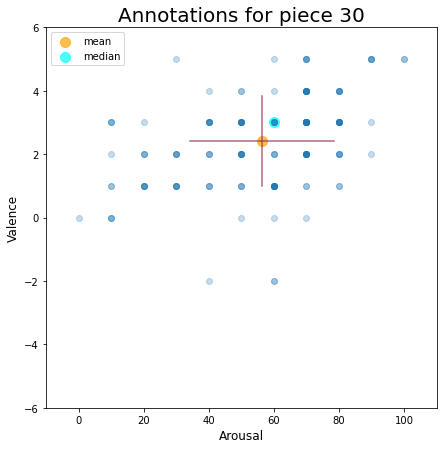

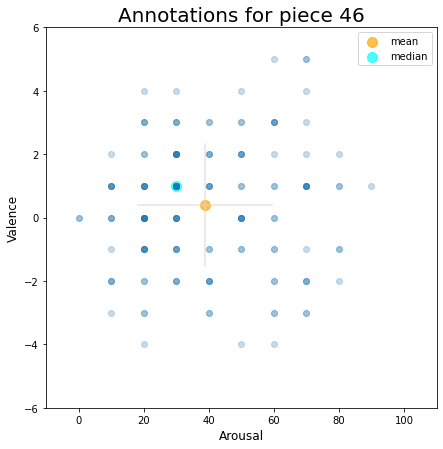

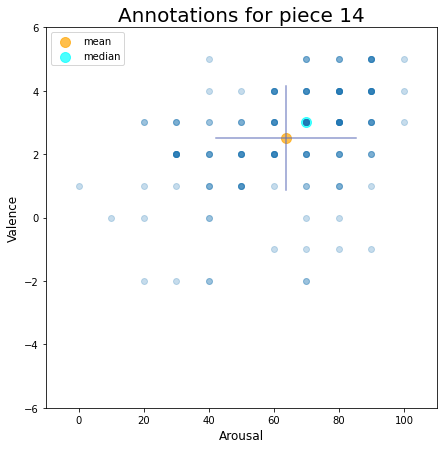

In [4]:

colors = plt.cm.get_cmap('twilight', len(piece_ids))

def plot_annotations(annotations, piece_id):
    filtered_annotations = annotations[annotations.piece == piece_id]
    arousal = filtered_annotations.arousal
    valence = filtered_annotations.valence
    
    a_m = arousal.mean()
    a_median = arousal.median()
    v_m = valence.mean()
    v_median = valence.median()
    
    p = plot_data.loc[piece_id]
    a_sd = p.a_sd
    v_sd = p.v_sd
    
    plt.figure(figsize=(7,7))

    plt.plot([a_m - a_sd, a_m + a_sd], [v_m, v_m], alpha=0.7, color=colors(piece_ids.tolist().index(piece_id)))
    plt.plot([a_m, a_m], [v_m-v_sd, v_m+v_sd], alpha=0.7, color=colors(piece_ids.tolist().index(piece_id)))
    
    plt.scatter(x=a_m, y=v_m, color="orange", s=100, alpha=0.7, label="mean")
    plt.scatter(x=a_median, y=v_median, color="cyan", s=100, alpha=0.7, label="median")
    plt.scatter(x=arousal, y=valence,  alpha=0.25)
    plt.title("Annotations for piece " + str(piece_id), fontsize=20)
    plt.xlabel("Arousal", fontsize=12)
    plt.legend()
    plt.ylabel("Valence", fontsize=12)
    plt.xlim(-10,110)
    plt.ylim(-6,6)
    plt.show()

n = 3

# randomly choose n elements:
sample_pieces = piece_ids[np.random.choice(len(piece_ids), size=n, replace=False)]

#np.random.sample(piece_ids)
for i in sample_pieces:
    plot_annotations(annotations, i)

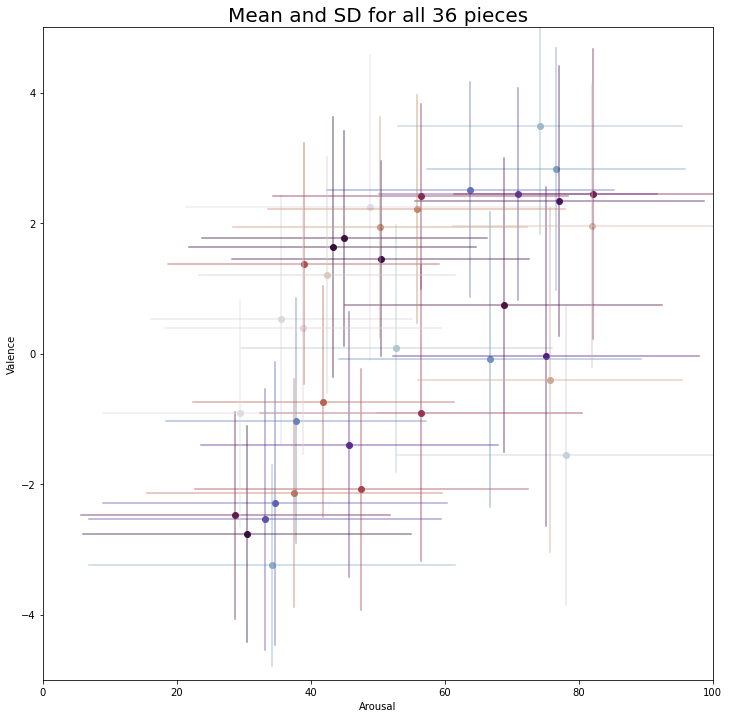

In [5]:

#plt.figure(figsize=(15,8))
plt.figure(figsize=(12,12))

for p_id in piece_ids:
    
    p = plot_data.loc[p_id]
    a_v = p.a_variance
    v_v = p.a_variance
    a_sd = p.a_sd
    v_sd = p.v_sd
    a_m = p.a_mean
    v_m = p.v_mean
    a_med = p.a_median
    v_med = p.v_median

    plt.scatter(x=a_m, y=v_m, color=colors(piece_ids.tolist().index(p_id)))
    plt.plot([a_m - a_sd, a_m + a_sd], [v_m, v_m], alpha=0.5, color=colors(piece_ids.tolist().index(p_id)))
    plt.plot([a_m, a_m], [v_m-v_sd, v_m+v_sd], alpha=0.5, color=colors(piece_ids.tolist().index(p_id)))
    plt.xlabel("Arousal")
    plt.ylabel("Valence")
    plt.ylim(-5,5)
    plt.xlim(0,100)
    

plt.title("Mean and SD for all 36 pieces", fontsize=20)
plt.show()

## converting mean valence+arousal to angle and radius

In [6]:
plot_data["v_mean_normalized"] = (plot_data.v_mean)/5
plot_data["a_mean_normalized"] = ((plot_data.a_mean)-50)/50.
plot_data["angle"] = 0.
plot_data["angle_shifted"] = 0.
import math
for piece in piece_ids:
    a = plot_data.a_mean_normalized[piece]
    v = plot_data.v_mean_normalized[piece]
    #print(a,v, math.atan2(v,a))
    plot_data.at[piece,"angle"] = math.atan2(v,a)
    plot_data.at[piece,"angle_shifted"] = plot_data.at[piece,"angle"] + np.pi*1/2
    if plot_data.at[piece,"angle_shifted"] > np.pi:
        plot_data.at[piece,"angle_shifted"] -= 2* np.pi
        
    plot_data.at[piece,"radius"] = np.sqrt(a**2 + v**2)
    
#plot_data

## Is there a correlation between Minorness and Valence/Arousal/Angle?

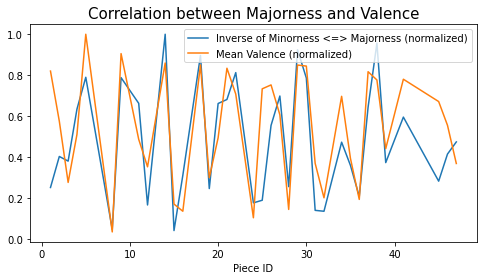

Pearson correlation coefficient between Minorness and VALENCE:
 -0.7640842859211436 => strong negative correlation

Pearson correlation coefficient between Minorness and AROUSAL:
 -0.6272804480952887 => moderate negative correlation

Pearson correlation coefficient between Minorness and ANGLE:
 -0.5213864365731204 => moderate negative correlation

Pearson correlation coefficient between Minorness and ANGLE (shifted):
 -0.7202040281237464 => strong negative correlation


In [7]:
# -> ["01", "02", "03",...,"46", "47"]
ids_str = ["%02d" % (p,) for p in piece_ids] 

piece_minorness = dict()
for p in range(len(ids_str)):
    piece = ids_str[p]
    piece_minorness[piece_ids[p]] = features[features.id.str.match('..-'+piece+'-')].midlevel_features_minorness.mean()


# (hab die werte erstmal größer skaliert damit wir gleich besser normieren können)
min_raw = [-100.*i for i in list(piece_minorness.values())]
majorness_normalized = [float(v)/max(min_raw) for v in min_raw]
val_raw = list(plot_data.v_mean)

plt.figure(figsize=(8,4))
plt.plot(piece_ids, majorness_normalized, label="Inverse of Minorness <=> Majorness (normalized)")

# normieren damit die werte zwischen 0 und 1 sind:
plt.plot(piece_ids, [(float(i)/max(val_raw) + 1)/2 for i in val_raw] , label="Mean Valence (normalized)")
plt.legend()
plt.xlabel("Piece ID")
plt.title("Correlation between Majorness and Valence", fontsize=15)
plt.show()

valence_minorness_corr = stats.pearsonr(list(piece_minorness.values()), list(plot_data.v_mean))
arousal_minorness_corr = stats.pearsonr(list(piece_minorness.values()), list(plot_data.a_mean))
angle_minorness_corr = stats.pearsonr(list(piece_minorness.values()), list(plot_data.angle))
angle_minorness_corr2 = stats.pearsonr(list(piece_minorness.values()), list(plot_data.angle_shifted))


print("Pearson correlation coefficient between Minorness and VALENCE:\n", valence_minorness_corr[0], 
      "=> strong negative correlation\n")

print("Pearson correlation coefficient between Minorness and AROUSAL:\n", arousal_minorness_corr[0], 
      "=> moderate negative correlation\n")

print("Pearson correlation coefficient between Minorness and ANGLE:\n", angle_minorness_corr[0], 
      "=> moderate negative correlation\n")

print("Pearson correlation coefficient between Minorness and ANGLE (shifted):\n", angle_minorness_corr2[0], 
      "=> strong negative correlation")

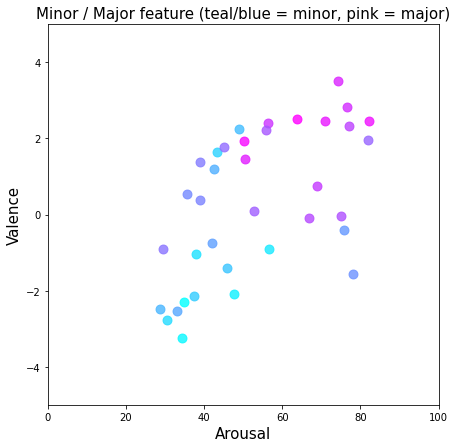

In [8]:
plt.figure(figsize=(7,7))

colors_min_maj = plt.cm.get_cmap('cool', len(piece_ids))

majorness_normalized

majorness_sorted = list(np.sort(majorness_normalized))

for p_id in piece_ids:
    p = plot_data.loc[p_id]
    a_m = p.a_mean
    v_m = p.v_mean
    
    majorness = majorness_normalized[piece_ids.tolist().index(p_id)]
    plt.scatter(x=a_m, y=v_m, s=80, color=colors_min_maj(majorness_sorted.index(majorness)), alpha=0.8)
    plt.xlabel("Arousal",fontsize=15)
    plt.ylabel("Valence",fontsize=15)
    plt.ylim(-5,5)
    plt.xlim(0,100)
    

plt.title("Minor / Major feature (teal/blue = minor, pink = major)", fontsize=15)
plt.show()

# Correlation between Features and Arousal/Valence

In [9]:
# -> ["01", "02", "03",...,"46", "47"]
ids_str = ["%02d" % (p,) for p in piece_ids] 

piece_minorness = dict()
for p in range(len(ids_str)):
    piece = ids_str[p]
    piece_minorness[piece_ids[p]] = features[features.id.str.match('..-'+piece+'-')].midlevel_features_minorness.mean()

In [10]:
mean_features_for_each_piece = dict()

for feature in list(features.columns):
    if feature == "id":
        continue
        
    mean_features_for_each_piece[feature] = dict()
    
    for p in range(len(ids_str)):
        piece_id_str = ids_str[p] # "01", "04", ..., "46", "47"
        piece_id = piece_ids[p] # 1, 4, ..., 46, 47
        
        #print(piece_id_str, features[features.id.str.match('..-'+piece_id_str+'-')])
        
        mean_features_for_each_piece[feature][piece_id] = features[features.id.str.match('..-'+piece_id_str+'-')][feature].mean()
    
correlation_features_arousal = dict()
correlation_features_valence = dict()

for feature, pieces in mean_features_for_each_piece.items():
    corr_a, _ = stats.pearsonr(list(pieces.values()), list(plot_data.a_mean))
    corr_v, _ = stats.pearsonr(list(pieces.values()), list(plot_data.v_mean))
    
    correlation_features_arousal[feature] = abs(corr_a)
    correlation_features_valence[feature] = abs(corr_v)

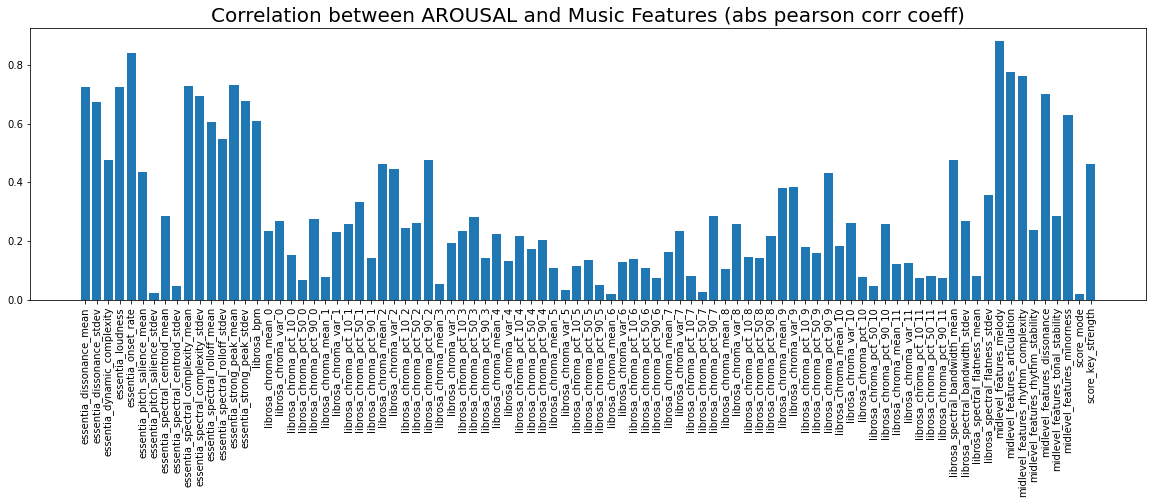

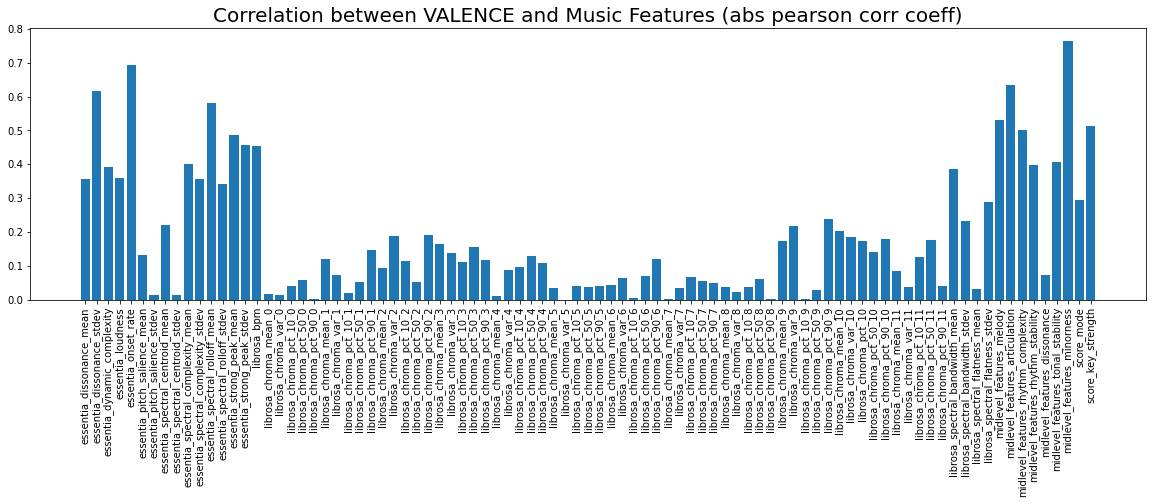

In [11]:
import operator

correlation_features_arousal_sorted = sorted(correlation_features_arousal.items(), key=operator.itemgetter(1))
correlation_features_valence_sorted = sorted(correlation_features_valence.items(), key=operator.itemgetter(1))


#plt.plot(correlation_features_arousal)
plt.figure(figsize=(20,5))
plt.bar(range(len(correlation_features_arousal)), list(correlation_features_arousal.values()), align='center')
plt.xticks(range(len(correlation_features_arousal)), list(correlation_features_arousal.keys()), rotation='vertical')
plt.title("Correlation between AROUSAL and Music Features (abs pearson corr coeff)", fontsize=20)
plt.show()


#plt.plot(correlation_features_arousal)
plt.figure(figsize=(20,5))
plt.bar(range(len(correlation_features_valence)), list(correlation_features_valence.values()), align='center')
plt.xticks(range(len(correlation_features_valence)), list(correlation_features_valence.keys()), rotation='vertical')
plt.title("Correlation between VALENCE and Music Features (abs pearson corr coeff)", fontsize=20)
plt.show()

In [12]:
print("###### BEST features to predict arousal (abs(pearson) > 0.7): ######\n ")

for k, v in correlation_features_arousal.items():
    if np.abs(v) > 0.7:
        print(k, "\t", v)
        
        
print("\n\n###### BEST features to predict valence (abs(pearson) > 0.63): ######\n")

for k, v in correlation_features_valence.items():
    if np.abs(v) > 0.55:
        print(k, "\t", v)
        

print("\n\n###### WORST features to predict arousal (abs(pearson) < 0.2): ######\n")

for k, v in correlation_features_arousal.items():
    if np.abs(v) < 0.2:
        print(k, "\t", v)
        
        
print("\n\n###### WORST features to predict valence (abs(pearson) < 0.2): ######\n")

for k, v in correlation_features_valence.items():
    if np.abs(v) < 0.2:
        print(k, "\t", v)

###### BEST features to predict arousal (abs(pearson) > 0.7): ######
 
essentia_dissonance_mean 	 0.723155467068827
essentia_loudness 	 0.7259262228875697
essentia_onset_rate 	 0.8412315211634332
essentia_spectral_complexity_mean 	 0.7286449203420293
essentia_strong_peak_mean 	 0.7299284303425366
midlevel_features_melody 	 0.8809981658412286
midlevel_features_articulation 	 0.7736216708601469
midlevel_features_rhythm_complexity 	 0.7610783949055999


###### BEST features to predict valence (abs(pearson) > 0.63): ######

essentia_dissonance_stdev 	 0.617060624397334
essentia_onset_rate 	 0.6934885041073837
essentia_spectral_rolloff_mean 	 0.5801822657009671
midlevel_features_articulation 	 0.6336226859320355
midlevel_features_minorness 	 0.7640842859211436


###### WORST features to predict arousal (abs(pearson) < 0.2): ######

essentia_pitch_salience_stdev 	 0.023550925571313996
essentia_spectral_centroid_stdev 	 0.04539795214051962
librosa_chroma_pct_10_0 	 0.1513267475429729
librosa_